## SEIRS data - 1 cycle, 2 cycle, and delta vs ngalenka region 

ngalenka is just south of podor where they did irrigation work

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme()

Read in the data. One file for the treatment area (west/delta), one file for the control area (east/podor).

In [12]:
tzo = pd.read_pickle('treatment_zone_observed.pkl') #treatment zone observed - tzo
czo = pd.read_pickle('control_zone_observed.pkl') #control zone observed - czo

Converting the column headers that are times into datetime objects.
This makes certain things later on a bit awkward (cannot use gpd.explore(), but makes plotting graphs easier)

In [13]:
t_timeseries = tzo.iloc[:, 4:-1]
c_timeseries = czo.iloc[:, 4:-1]

t_timeseries.columns = pd.to_datetime(t_timeseries.columns, format='%Y_%m_%d')
t_timeseries = gpd.GeoDataFrame(t_timeseries, geometry=tzo.geometry)
t_timeseries.index = tzo['id']

c_timeseries.columns = pd.to_datetime(c_timeseries.columns, format='%Y_%m_%d')
c_timeseries = gpd.GeoDataFrame(c_timeseries, geometry=czo.geometry)
c_timeseries.index = czo['id']

Define our sites, split up by site type (according to the MCC/Mathematica report)

Hot and Rain are sites that produce a single crop in a year, during either the hot or rainy seasons.

Both are sites that do at least a double crop cycle in a year.

Ngalenka are three sites that were irrigate in the Podor region. We might need to compare these to podor sites that had no intervention, which I have not selected yet.

In [16]:
# define our site classes and ids
delta_hot_ix = [640686, 494877, 750802]
delta_rain_ix = [542439, 625750, 479986]
delta_both_ix = [599039, 652544, 658545]
ngalenka_ix = [257258, 263217, 263214]

Cross reference site IDs with the observed datasets:

In [18]:
delta_hot = t_timeseries.loc[delta_hot_ix]
delta_rain = t_timeseries.loc[delta_rain_ix]
delta_both = t_timeseries.loc[delta_both_ix]
ngalenka = c_timeseries.loc[ngalenka_ix]

In [19]:
delta_hot

,2011-04-23 00:00:00,2011-05-09 00:00:00,2011-05-25 00:00:00,2011-06-10 00:00:00,2011-06-26 00:00:00,2011-07-12 00:00:00,2011-07-28 00:00:00,2011-08-13 00:00:00,2011-08-29 00:00:00,2011-09-14 00:00:00,...,2018-06-26 00:00:00,2018-07-12 00:00:00,2018-07-28 00:00:00,2018-08-13 00:00:00,2018-08-29 00:00:00,2018-09-14 00:00:00,2018-09-30 00:00:00,2018-10-16 00:00:00,2018-11-01 00:00:00,geometry
id,,,,,,,,,,,,,,,,,,,,,
640686.0,0.4659,0.4154,0.4004,0.3632,0.2525,0.242,0.2163,0.1701,0.3635,0.5256,...,0.4149,0.4104,0.3382,0.2661,0.3455,0.4251,0.4854,0.3643,0.3026,POINT (-16.22835 16.24479)
494877.0,0.2430,0.2329,0.2480,0.2517,0.2158,0.216,0.1785,0.2970,0.4156,0.5659,...,0.6215,0.5457,0.4318,0.3357,0.3919,0.5289,0.5782,0.4646,0.3511,POINT (-16.09501 16.34688)
750802.0,0.5066,0.4372,0.4382,0.3529,0.2505,0.389,0.1485,0.3513,0.5542,0.6157,...,0.4636,0.4259,0.4082,0.3881,0.4772,0.5664,0.6056,0.3907,0.2551,POINT (-16.29710 16.16771)


Map:

In [20]:
map = folium.Map(location=[16.3, -16], zoom_start=9)

colors = ['yellow', 'blue', 'green', 'orange']

for i,j in enumerate([delta_hot, delta_rain, delta_both, ngalenka]):
    for _,r in j.iterrows():
        folium.CircleMarker(location=[r['geometry'].y, r['geometry'].x], radius=5, color=colors[i], fill=True).add_to(map)

# delta_hot.iloc[:, 4:].explore(m=map, marker_kwds=dict(radius=5, color='yellow', fill=True), name='1 cycle - hot', tooltip='id', tooltip_kwds=dict(labels=False))
# delta_rain.iloc[:, 4:].explore(m=map, marker_kwds=dict(radius=5, color='blue', fill=True), name='1 cycle - rain', tooltip='id', tooltip_kwds=dict(labels=False))
# delta_both.iloc[:, 4:].explore(m=map, marker_kwds=dict(radius=5, color='green', fill=True), name='2 cycles', tooltip='id', tooltip_kwds=dict(labels=False))
# ngalenka.iloc[:, 4:].explore(m=map, marker_kwds=dict(radius=5, color='orange', fill=True), name='2 cycles', tooltip='id', tooltip_kwds=dict(labels=False))

fig = folium.Figure(figsize=(16,9))
fig.add_child(map)

Plot timeseries information:

Ok, so here I may just define a set of new dataframes so that I can keep the columns as datetimeindex.

Once you try and include geometry separately, it turns the columns into index, which prevents you from using lots of time based functions in python/pandas.

In [58]:
delta_hot_time = delta_hot.drop('geometry', axis=1).rename(columns=pd.to_datetime)
delta_rain_time = delta_rain.drop('geometry', axis=1).rename(columns=pd.to_datetime)
delta_both_time = delta_both.drop('geometry', axis=1).rename(columns=pd.to_datetime)
ngalenka_time = ngalenka.drop('geometry', axis=1).rename(columns=pd.to_datetime)

In [57]:
delta_hot_time.columns

DatetimeIndex(['2011-04-23', '2011-05-09', '2011-05-25', '2011-06-10',
               '2011-06-26', '2011-07-12', '2011-07-28', '2011-08-13',
               '2011-08-29', '2011-09-14',
               ...
               '2018-06-10', '2018-06-26', '2018-07-12', '2018-07-28',
               '2018-08-13', '2018-08-29', '2018-09-14', '2018-09-30',
               '2018-10-16', '2018-11-01'],
              dtype='datetime64[ns]', length=174, freq=None)

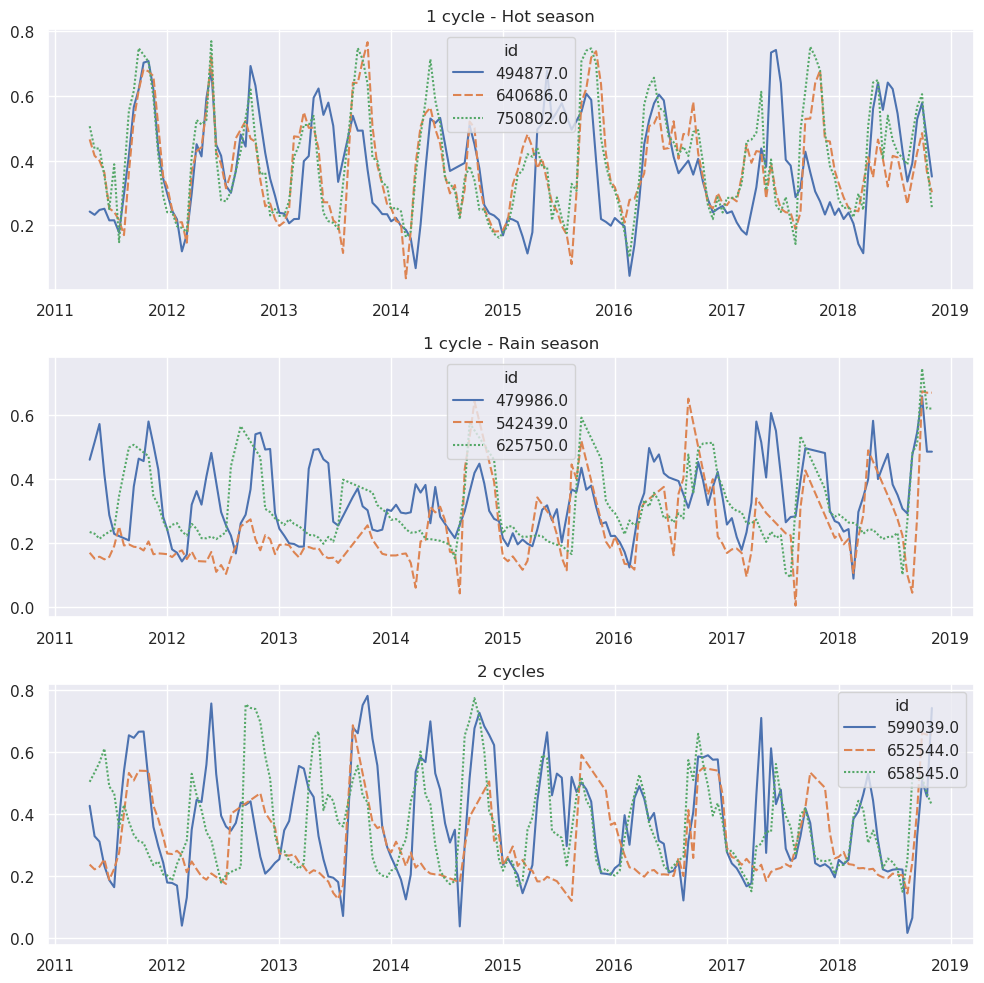

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.lineplot(data=delta_hot_time.T, ax=axes[0], c='y')
sns.lineplot(data=delta_rain_time.T, ax=axes[1])
sns.lineplot(data=delta_both_time.T, ax=axes[2])

axes[0].set_title('1 cycle - Hot season')
axes[1].set_title('1 cycle - Rain season')
axes[2].set_title('2 cycles')
plt.tight_layout()


It is very hard to tell if there are more apparent cycles in any of these sites.
Lets look at ngalenka:

<AxesSubplot: >

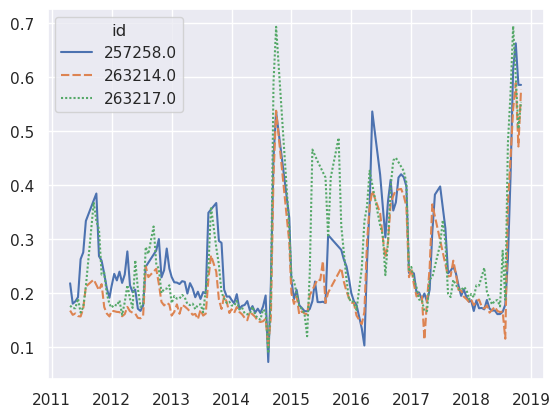

In [68]:
sns.lineplot(data=ngalenka_time.T)

Wow, ok, well whatever about cycles. 
There is definitely a huge increase in NDVI observed after the irrigation interventions (around 2015 right?) at these sites! 

Would be interesting to look at these sites in predicted NDVI!

<AxesSubplot: >

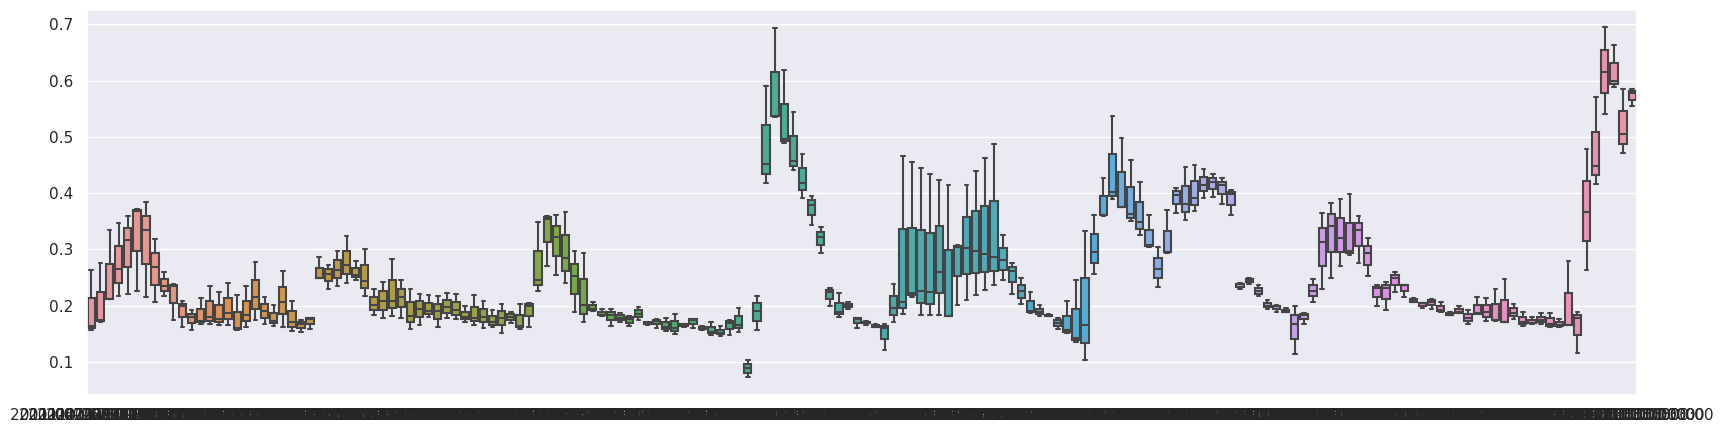

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(data=ngalenka.T[4:-1].T, ax = ax)

In [69]:
tzf = pd.read_pickle('treatment_zone_forecast.pkl') #treatment zone observed - tzo
czf = pd.read_pickle('control_zone_forecast.pkl') #control zone observed - czo

In [74]:
tzf = tzf[:,4:-1]
tzf.drop('geometry', axis=1).rename(columns=pd.to_datetime)

InvalidIndexError: (slice(None, None, None), slice(4, -1, None))

In [82]:
sites_ix = delta_hot_ix + delta_rain_ix + delta_both_ix + ngalenka_ix

In [88]:
tzf = tzf.loc[tzf['id'].isin(sites_ix)]

In [89]:
tzf

,id,lon,lat,cluster,2011_04_23,2011_05_09,2011_05_25,2011_06_10,2011_06_26,2011_07_12,...,2018_06_26,2018_07_12,2018_07_28,2018_08_13,2018_08_29,2018_09_14,2018_09_30,2018_10_16,2018_11_01,geometry
664,479986.0,-16.107514,16.357292,86.0,0.4355,0.3937,0.3531,0.3123,0.2926,0.2887,...,0.3023,0.3095,0.3088,0.3681,0.4119,0.4540,0.5067,0.5359,0.5566,POINT (-16.10751 16.35729)
676,494877.0,-16.095014,16.346875,80.0,0.2098,0.2151,0.2117,0.2329,0.2570,0.2651,...,0.3016,0.3180,0.3235,0.3935,0.4380,0.4969,0.5628,0.6087,0.6600,POINT (-16.09501 16.34688)
716,542439.0,-16.240847,16.313542,86.0,0.1737,0.1726,0.1729,0.1656,0.1426,0.1194,...,0.1953,0.2015,0.2164,0.2678,0.2968,0.3166,0.3548,0.3665,0.3748,POINT (-16.24085 16.31354)
756,599039.0,-16.163764,16.273958,5.0,0.4232,0.3688,0.3237,0.2893,0.2488,0.2140,...,0.2736,0.2862,0.3053,0.3767,0.4304,0.4699,0.5180,0.5323,0.5361,POINT (-16.16376 16.27396)
766,625750.0,-16.334597,16.255208,23.0,0.1764,0.1965,0.2261,0.2566,0.3008,0.3412,...,0.3400,0.3691,0.3847,0.4415,0.4512,0.4510,0.4572,0.4644,0.4758,POINT (-16.33460 16.25521)
777,640686.0,-16.228347,16.244792,5.0,0.3581,0.3201,0.2716,0.2414,0.2421,0.2342,...,0.2245,0.2450,0.2749,0.3672,0.4242,0.4506,0.4864,0.4887,0.4894,POINT (-16.22835 16.24479)
779,652544.0,-16.332514,16.236458,37.0,0.1767,0.1865,0.2104,0.2389,0.2818,0.3247,...,0.3243,0.3482,0.3453,0.4081,0.4116,0.4097,0.4140,0.4275,0.4424,POINT (-16.33251 16.23646)
783,658545.0,-16.234597,16.232292,5.0,0.3632,0.3778,0.3458,0.3086,0.2860,0.2614,...,0.2181,0.2294,0.2521,0.3407,0.3957,0.4262,0.4666,0.4743,0.4763,POINT (-16.23460 16.23229)
804,750802.0,-16.297097,16.167708,32.0,0.4960,0.4645,0.4120,0.3749,0.3072,0.2614,...,0.2742,0.2776,0.2693,0.3420,0.3781,0.4195,0.4588,0.4843,0.4954,POINT (-16.29710 16.16771)
